In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('SBIN.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,18.691147,18.978922,18.540184,18.823240,12.409934,43733533
1996-01-02,18.894005,18.964767,17.738192,18.224106,12.014935,56167280
1996-01-03,18.327892,18.568489,17.643839,17.738192,11.694573,68296318
1996-01-04,17.502312,17.832542,17.223972,17.676863,11.654140,86073880
1996-01-05,17.738192,17.785366,17.459852,17.577793,11.588824,76613039


In [5]:
# to check dates in index
df.index

DatetimeIndex(['1996-01-01', '1996-01-02', '1996-01-03', '1996-01-04',
               '1996-01-05', '1996-01-08', '1996-01-09', '1996-01-10',
               '1996-01-11', '1996-01-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=6912, freq=None)

In [6]:
df.shape

(6912, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,566.349976,569.000000,561.049988,562.950012,562.950012,14979063
2023-06-23,562.000000,562.099976,553.799988,554.599976,554.599976,12215712
2023-06-26,556.000000,558.500000,554.500000,557.049988,557.049988,8360264
2023-06-27,558.250000,567.950012,555.650024,566.099976,566.099976,10694768
2023-06-30,574.000000,574.000000,570.200012,572.849976,572.849976,8711121


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6912 entries, 1996-01-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6912 non-null   float64
 1   High       6912 non-null   float64
 2   Low        6912 non-null   float64
 3   Close      6912 non-null   float64
 4   Adj Close  6912 non-null   float64
 5   Volume     6912 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 378.0 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

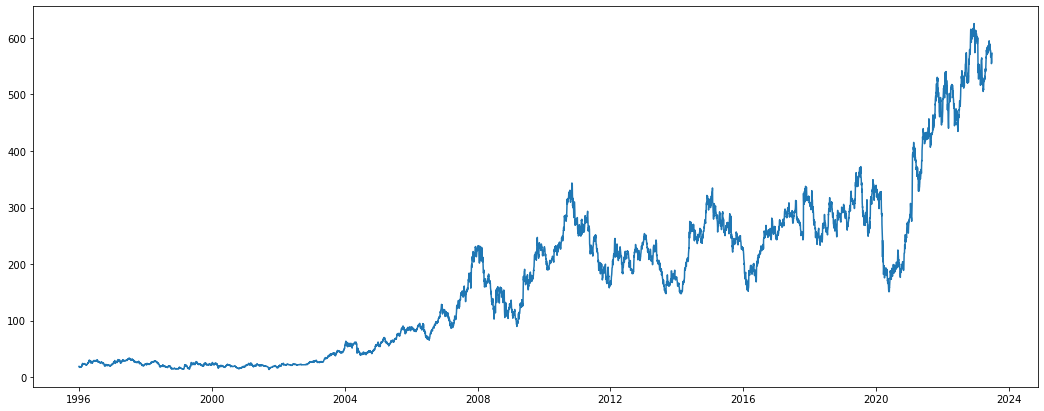

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  18.691146850585938
Ending price:  572.8499755859375


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  1996-01-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
1996-01-01,18.691147,18.823240
1996-01-02,18.894005,18.224106
1996-01-03,18.327892,17.738192
1996-01-04,17.502312,17.676863
1996-01-05,17.738192,17.577793


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[0.00894732],
       [0.00796859],
       [0.00717481],
       ...,
       [0.88818169],
       [0.90296554],
       [0.91399218]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(4838, 2074)

In [21]:
train_data

array([[0.00894732],
       [0.00796859],
       [0.00717481],
       ...,
       [0.48289149],
       [0.48052279],
       [0.46876102]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[0.00894732, 0.00796859, 0.00717481, ..., 0.00726729, 0.00754473,
        0.00754473],
       [0.00796859, 0.00717481, 0.00707463, ..., 0.00754473, 0.00754473,
        0.00888567],
       [0.00717481, 0.00707463, 0.00691279, ..., 0.00754473, 0.00888567,
        0.00957155],
       ...,
       [0.48762885, 0.49114103, 0.493183  , ..., 0.51311265, 0.51735991,
        0.52479271],
       [0.49114103, 0.493183  , 0.48909906, ..., 0.51735991, 0.52479271,
        0.51237752],
       [0.493183  , 0.48909906, 0.4681076 , ..., 0.52479271, 0.51237752,
        0.48289149]])

In [25]:
y_train

array([0.00888567, 0.00957155, 0.00850034, ..., 0.51237752, 0.48289149,
       0.48052279])

In [26]:
X_test

array([[0.45691759, 0.45324205, 0.45242526, ..., 0.47153812, 0.47251828,
        0.45822448],
       [0.45324205, 0.45242526, 0.43478266, ..., 0.47251828, 0.45822448,
        0.45814278],
       [0.45242526, 0.43478266, 0.44752453, ..., 0.45822448, 0.45814278,
        0.45299702],
       ...,
       [0.93547374, 0.95017593, 0.94658204, ..., 0.90508927, 0.90337393,
        0.89781983],
       [0.95017593, 0.94658204, 0.92542721, ..., 0.90337393, 0.89781983,
        0.88417941],
       [0.94658204, 0.92542721, 0.93016462, ..., 0.89781983, 0.88417941,
        0.88818169]])

In [27]:
print(X_train.shape) 

(4817, 20)


In [28]:
print(y_train.shape)

(4817,)


In [29]:
print(X_test.shape)

(2053, 20)


In [30]:
print(ytest.shape)

(2053,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(4817, 20, 1)

In [33]:
X_train

array([[[0.00894732],
        [0.00796859],
        [0.00717481],
        ...,
        [0.00726729],
        [0.00754473],
        [0.00754473]],

       [[0.00796859],
        [0.00717481],
        [0.00707463],
        ...,
        [0.00754473],
        [0.00754473],
        [0.00888567]],

       [[0.00717481],
        [0.00707463],
        [0.00691279],
        ...,
        [0.00754473],
        [0.00888567],
        [0.00957155]],

       ...,

       [[0.48762885],
        [0.49114103],
        [0.493183  ],
        ...,
        [0.51311265],
        [0.51735991],
        [0.52479271]],

       [[0.49114103],
        [0.493183  ],
        [0.48909906],
        ...,
        [0.51735991],
        [0.52479271],
        [0.51237752]],

       [[0.493183  ],
        [0.48909906],
        [0.4681076 ],
        ...,
        [0.52479271],
        [0.51237752],
        [0.48289149]]])

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
151/151 [==============================] - 5s 17ms/step - loss: 0.0034 - val_loss: 9.3477e-04
Epoch 2/100
151/151 [==============================] - 2s 13ms/step - loss: 4.9616e-04 - val_loss: 5.4637e-04
Epoch 3/100
151/151 [==============================] - 2s 13ms/step - loss: 4.0827e-04 - val_loss: 5.5006e-04
Epoch 4/100
151/151 [==============================] - 2s 14ms/step - loss: 3.3142e-04 - val_loss: 6.7057e-04
Epoch 5/100
151/151 [==============================] - 2s 12ms/step - loss: 3.1535e-04 - val_loss: 0.0021
Epoch 6/100
151/151 [==============================] - 2s 12ms/step - loss: 3.3815e-04 - val_loss: 7.1214e-04
Epoch 7/100
151/151 [==============================] - 2s 12ms/step - loss: 2.9715e-04 - val_loss: 0.0012
Epoch 8/100
151/151 [==============================] - 2s 12ms/step - loss: 2.7191e-04 - val_loss: 5.6858e-04
Epoch 9/100
151/151 [==============================] - 2s 12ms/step - loss: 2.7480e-04 - val_loss: 4.0950e-04
Epoch 10/100
151/151 [

151/151 [==============================] - 2s 13ms/step - loss: 1.4978e-04 - val_loss: 1.5390e-04
Epoch 76/100
151/151 [==============================] - 2s 14ms/step - loss: 1.5298e-04 - val_loss: 1.5572e-04
Epoch 77/100
151/151 [==============================] - 3s 17ms/step - loss: 1.5176e-04 - val_loss: 2.4941e-04
Epoch 78/100
151/151 [==============================] - 2s 13ms/step - loss: 1.4624e-04 - val_loss: 1.3388e-04
Epoch 79/100
151/151 [==============================] - 2s 12ms/step - loss: 1.4794e-04 - val_loss: 1.2879e-04
Epoch 80/100
151/151 [==============================] - 2s 12ms/step - loss: 1.4704e-04 - val_loss: 2.1987e-04
Epoch 81/100
151/151 [==============================] - 2s 12ms/step - loss: 1.4926e-04 - val_loss: 1.6085e-04
Epoch 82/100
151/151 [==============================] - 2s 12ms/step - loss: 1.3664e-04 - val_loss: 4.1799e-04
Epoch 83/100
151/151 [==============================] - 2s 12ms/step - loss: 1.5333e-04 - val_loss: 1.4535e-04
Epoch 84/100
1

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

65/65 [==============================] - 0s 5ms/step


In [39]:
train_predict

array([[0.00705151],
       [0.00812382],
       [0.00897057],
       ...,
       [0.51483816],
       [0.50179887],
       [0.4730584 ]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[ 17.662714],
       [ 18.319128],
       [ 18.837473],
       ...,
       [328.5063  ],
       [320.52423 ],
       [302.93063 ]], dtype=float32)

In [42]:
test_predict

array([[288.48813],
       [288.78625],
       [285.65234],
       ...,
       [546.0127 ],
       [537.277  ],
       [542.2818 ]], dtype=float32)

In [43]:
ytest

array([0.45814278, 0.45299702, 0.44801463, ..., 0.88417941, 0.88818169,
       0.90296554])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


135.12247015397628

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

340.9581761213052

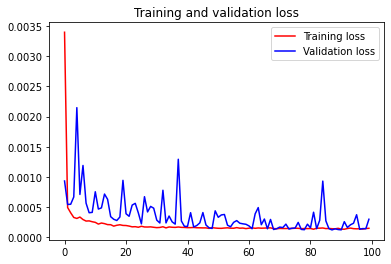

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

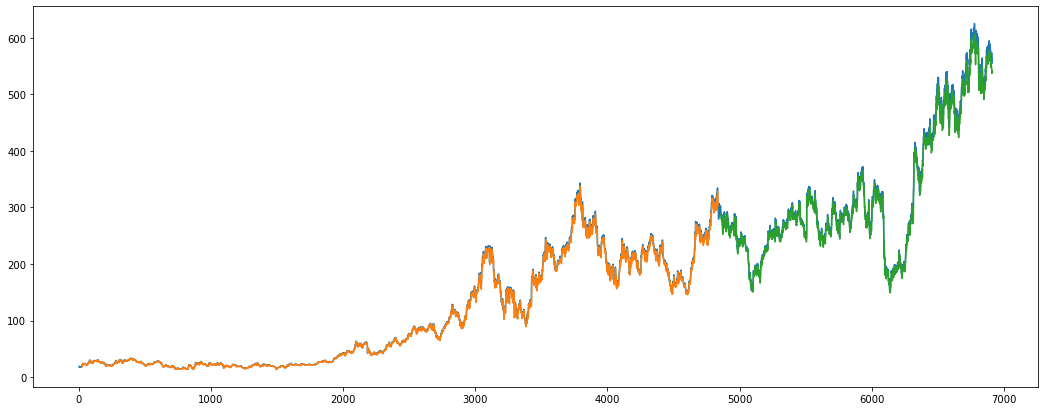

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.45814278, 0.45299702, 0.44801463, ..., 0.88417941, 0.88818169,
       0.90296554])

In [49]:
test_predict

array([[288.48813],
       [288.78625],
       [285.65234],
       ...,
       [546.0127 ],
       [537.277  ],
       [542.2818 ]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

2053

In [52]:
test_predict1

array([288.48813, 288.78625, 285.65234, ..., 546.0127 , 537.277  ,
       542.2818 ], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.45814278, 0.45299702, 0.44801463, ..., 0.88417941, 0.88818169,
        0.90296554]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[293.79998779, 290.6499939 , 287.6000061 , ..., 554.59997559,
        557.04998779, 566.09997559]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

2053

In [60]:
df2 = df.iloc[4859:,:]

In [61]:
len(df2)

2053

In [62]:
df2.head()

,Open,Close
Date,,
2015-03-09,292.000000,290.649994
2015-03-10,290.750000,287.600006
2015-03-11,288.549988,285.149994
2015-03-12,288.149994,286.850006
2015-03-13,290.000000,280.750000


In [63]:
df2['predicted'] = test_predict1

In [64]:
df2.head(20)

,Open,Close,predicted
Date,,,
2015-03-09,292.000000,290.649994,288.488129
2015-03-10,290.750000,287.600006,288.786255
2015-03-11,288.549988,285.149994,285.652344
2015-03-12,288.149994,286.850006,282.752197
2015-03-13,290.000000,280.750000,280.357635
2015-03-16,281.500000,281.649994,282.044678
2015-03-17,283.899994,283.100006,275.950409
2015-03-18,284.100006,287.299988,276.939850
2015-03-19,290.000000,281.600006,278.303772


In [65]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2053 entries, 2015-03-09 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2053 non-null   float64
 1   Close      2053 non-null   float64
 2   predicted  2053 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 56.1 KB


In [66]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,566.349976,562.950012,550.988281
2023-06-23,562.000000,554.599976,549.411926
2023-06-26,556.000000,557.049988,546.012695
2023-06-27,558.250000,566.099976,537.276978
2023-06-30,574.000000,572.849976,542.281799


In [67]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [68]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2015-03-09,292.000000,290.649994,288.488129,-2.161865
2015-03-10,290.750000,287.600006,288.786255,1.186249
2015-03-11,288.549988,285.149994,285.652344,0.502350
2015-03-12,288.149994,286.850006,282.752197,-4.097809
2015-03-13,290.000000,280.750000,280.357635,-0.392365


In [69]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [70]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2015-03-09,292.000000,290.649994,288.488129,-2.161865,0
2015-03-10,290.750000,287.600006,288.786255,1.186249,1
2015-03-11,288.549988,285.149994,285.652344,0.502350,1
2015-03-12,288.149994,286.850006,282.752197,-4.097809,0
2015-03-13,290.000000,280.750000,280.357635,-0.392365,0


In [71]:
df2.drop(columns='temp_signal',inplace = True)

In [72]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2015-03-09,292.000000,290.649994,288.488129,0
2015-03-10,290.750000,287.600006,288.786255,1
2015-03-11,288.549988,285.149994,285.652344,1
2015-03-12,288.149994,286.850006,282.752197,0
2015-03-13,290.000000,280.750000,280.357635,0


In [73]:
signal = list(df2['signal'])

In [74]:
signal

[0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,


In [75]:
signal.insert(0,999)

In [76]:
signal

[999,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1

In [77]:
len(df2)

2053

In [78]:
len(signal)

2054

In [79]:
signal.pop()

0

In [80]:
len(signal)

2053

In [81]:
new_signal = np.array(signal)

In [82]:
new_signal

array([999,   0,   1, ...,   0,   0,   0])

In [83]:
df2['new_signal'] = new_signal

In [84]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2015-03-09,292.000000,290.649994,288.488129,0,999
2015-03-10,290.750000,287.600006,288.786255,1,0
2015-03-11,288.549988,285.149994,285.652344,1,1
2015-03-12,288.149994,286.850006,282.752197,0,1
2015-03-13,290.000000,280.750000,280.357635,0,0


In [85]:
df2.drop(columns = 'signal',inplace = True)

In [86]:
df3 = df2[df2['new_signal']==1]

In [87]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-11,288.549988,285.149994,285.652344,1
2015-03-12,288.149994,286.850006,282.752197,1
2015-03-17,283.899994,283.100006,275.950409,1
2015-03-23,279.399994,274.750000,276.708374,1
2015-03-24,273.799988,270.549988,273.550293,1


In [88]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [89]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-11,288.549988,285.149994,285.652344,1,-3.399994
2015-03-12,288.149994,286.850006,282.752197,1,-1.299988
2015-03-17,283.899994,283.100006,275.950409,1,-0.799988
2015-03-23,279.399994,274.750000,276.708374,1,-4.649994
2015-03-24,273.799988,270.549988,273.550293,1,-3.250000


In [90]:
df3['profit_loss'].sum()

-257.69993591308594

In [91]:
df4 = df2[df2['new_signal']==0]

In [92]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [93]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-10,290.750000,287.600006,288.786255,0,3.149994
2015-03-13,290.000000,280.750000,280.357635,0,9.250000
2015-03-16,281.500000,281.649994,282.044678,0,-0.149994
2015-03-18,284.100006,287.299988,276.939850,0,-3.199982
2015-03-19,290.000000,281.600006,278.303772,0,8.399994


In [94]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-09,292.000000,290.649994,288.488129,999
2015-03-10,290.750000,287.600006,288.786255,0
2015-03-11,288.549988,285.149994,285.652344,1
2015-03-12,288.149994,286.850006,282.752197,1
2015-03-13,290.000000,280.750000,280.357635,0


In [95]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,566.349976,562.950012,550.988281,0
2023-06-23,562.000000,554.599976,549.411926,0
2023-06-26,556.000000,557.049988,546.012695,0
2023-06-27,558.250000,566.099976,537.276978,0
2023-06-30,574.000000,572.849976,542.281799,0


In [96]:
df4['profit_loss'].sum()

661.0506591796875

In [97]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [98]:
Total_profit

403.35072326660156

In [99]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  292.0
Ending price:  542.2817993164062


In [100]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

250.28179931640625

In [101]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

153.0689239501953

In [102]:
len(df3)

462

In [103]:
len(df4)

1590

In [104]:
len(df2)

2053